# All

## Import/read

In [185]:
import os
import warnings
from datetime import datetime

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [2]:
data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"


def r(filename, sub_folder="kaggle", delimiter=","):
    return pd.read_csv(
        os.path.join(data_path, sub_folder, filename), delimiter=delimiter
    )

In [3]:
df_census = r("census_starter.csv")
df_test = r("test.csv")
df_train = r("train.csv")
df_submission = r("sample_submission.csv")

df_boundaries = r("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")

### Fix dates, add year etc

In [4]:
def fix_df_train(df_train):
    # Add year
    df_train["first_day_of_month"] = pd.to_datetime(df_train["first_day_of_month"])
    df_train["year"] = df_train["first_day_of_month"].dt.year.astype(int)

    # Add df_census to df_train
    cols = list(df_census.columns)
    cols.remove("cfips")

    t0 = df_census.melt("cfips", cols)
    t0["year"] = t0["variable"].str.split("_").str[-1].astype(int)
    t0["variable_name"] = t0["variable"].str.rsplit("_", expand=False, n=1).str[0]

    t1 = pd.pivot_table(t0, "value", ["cfips", "year"], "variable_name").reset_index()

    df_train = pd.merge(
        df_train, t1, "left", left_on=["cfips", "year"], right_on=["cfips", "year"]
    )

    # Add month
    df_train["month"] = df_train["first_day_of_month"].dt.month

    return df_train

In [5]:
df_train = fix_df_train(df_train)

### Weather save/load

In [6]:
def save_weather_data(path_weather):
    # Temperatures
    temps = df_boundaries[["NAME", "NAMELSAD", "INTPTLAT", "INTPTLON"]].copy()
    temps["min_date"] = df_train["first_day_of_month"].min()
    temps["max_date"] = df_train["first_day_of_month"].max()

    data_list = []
    for idx, row in temps.iterrows():
        p = Point(row["INTPTLAT"], row["INTPTLON"], 70)

        data = Monthly(p, row["min_date"], row["max_date"])
        data = data.fetch()

        if data.shape[0] > 0:

            data["state"] = row["NAME"]
            data["county"] = row["NAMELSAD"]

            data_list.append(data)

        if idx % 100 == 0:
            print(idx)

    weather_data = pd.concat(data_list)
    weather_data.to_csv(path_weather)

In [7]:
df_boundaries

,Geo Point,Geo Shape,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,STUSAB,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,STATE_NAME,COUNTYFP NOZERO
0,"40.1763796295, -98.0471849897","{""coordinates"": [[[-98.273667, 40.089399], [-9...",31,129,835886,31129,Nuckolls,Nuckolls County,NE,6,H1,G4020,NaN,NaN,NaN,A,1489645188,1718484,40.176492,-98.046842,Nebraska,129
1,"40.7715207081, -84.1057794323","{""coordinates"": [[[-84.397189, 40.786584], [-8...",39,3,1074015,39003,Allen,Allen County,OH,6,H1,G4020,338.0,30620.0,NaN,A,1042479889,11259523,40.771627,-84.106103,Ohio,3
2,"41.9103521337, -81.250939242","{""coordinates"": [[[-81.488643, 41.631522], [-8...",39,85,1074055,39085,Lake,Lake County,OH,6,H1,G4020,184.0,17460.0,NaN,A,593807218,1942301625,41.924116,-81.392643,Ohio,85
3,"37.5023005833, -94.3471107747","{""coordinates"": [[[-94.617088, 37.477776], [-9...",29,11,758460,29011,Barton,Barton County,MO,6,H1,G4020,NaN,NaN,NaN,A,1533351029,12152201,37.500799,-94.344089,Missouri,11
4,"45.151770859, -86.0384960523","{""coordinates"": [[[-85.561745, 44.952258], [-8...",26,89,1622987,26089,Leelanau,Leelanau County,MI,6,H1,G4020,NaN,45900.0,NaN,A,899241895,5659105307,45.146182,-86.051574,Michigan,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,"31.8133256702, -95.6525471812","{""coordinates"": [[[-95.677533, 32.051631], [-9...",48,1,1383786,48001,Anderson,Anderson County,TX,6,H1,G4020,NaN,37300.0,NaN,A,2752201306,39808595,31.841261,-95.661727,Texas,1
3229,"38.0267183008, -77.3470467441","{""coordinates"": [[[-77.551611, 38.073609], [-7...",51,33,1480107,51033,Caroline,Caroline County,VA,6,H1,G4020,NaN,NaN,NaN,A,1366502847,24928486,38.030319,-77.352348,Virginia,33
3230,"45.1719349421, -96.7676947106","{""coordinates"": [[[-97.226066, 45.209924], [-9...",46,51,1265782,46051,Grant,Grant County,SD,6,H1,G4020,NaN,NaN,NaN,A,1764937242,15765681,45.172637,-96.772261,South Dakota,51
3231,"40.31072723, -79.4669607014","{""coordinates"": [[[-79.61818, 40.644766], [-79...",42,129,1209191,42129,Westmoreland,Westmoreland County,PA,6,H1,G4020,430.0,38300.0,NaN,A,2662612862,20837789,40.311068,-79.466688,Pennsylvania,129


In [8]:
path_weather = "../data/other/weather/weather.csv"
# save_weather_data(path_weather)

In [9]:
df_weather = pd.read_csv(path_weather)

In [10]:
df_weather

,time,tavg,tmin,tmax,prcp,wspd,pres,tsun,state,county
0,2019-08-01,23.3,18.3,28.5,NaN,NaN,NaN,NaN,Allen,Allen County
1,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allen,Allen County
2,2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allen,Allen County
3,2019-11-01,4.1,-0.0,8.4,NaN,NaN,NaN,NaN,Allen,Allen County
4,2019-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allen,Allen County
...,...,...,...,...,...,...,...,...,...,...
67317,2022-06-01,20.1,13.9,25.4,59.1,16.0,1011.0,NaN,Roseau,Roseau County
67318,2022-07-01,22.2,17.0,27.3,132.2,12.9,1012.8,NaN,Roseau,Roseau County
67319,2022-08-01,21.3,15.5,26.9,98.4,10.9,1014.6,NaN,Roseau,Roseau County
67320,2022-09-01,16.3,10.3,22.0,55.3,12.8,1015.9,NaN,Roseau,Roseau County


In [11]:
df_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,58731.0,80.6,16.1,2.3,0.7,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,58731.0,80.6,16.1,2.3,0.7,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,58731.0,80.6,16.1,2.3,0.7,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,6
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,7
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,8
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,9


In [12]:
df_weather

,time,tavg,tmin,tmax,prcp,wspd,pres,tsun,state,county
0,2019-08-01,23.3,18.3,28.5,NaN,NaN,NaN,NaN,Allen,Allen County
1,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allen,Allen County
2,2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allen,Allen County
3,2019-11-01,4.1,-0.0,8.4,NaN,NaN,NaN,NaN,Allen,Allen County
4,2019-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Allen,Allen County
...,...,...,...,...,...,...,...,...,...,...
67317,2022-06-01,20.1,13.9,25.4,59.1,16.0,1011.0,NaN,Roseau,Roseau County
67318,2022-07-01,22.2,17.0,27.3,132.2,12.9,1012.8,NaN,Roseau,Roseau County
67319,2022-08-01,21.3,15.5,26.9,98.4,10.9,1014.6,NaN,Roseau,Roseau County
67320,2022-09-01,16.3,10.3,22.0,55.3,12.8,1015.9,NaN,Roseau,Roseau County


### Baseline model

#### Feature functions

In [137]:
def add_previous_targets(df_train, added_feature_cols, windows=None, shifts=None):
    """
    Add rolling windows and/or shifted values

    window: list
        List of windows to add. [2, 5] will add two columns with rolling window 2 and 5.
    shifts: list
        List of recents shifts to add. [2, 5] will add two columns with shifts of 2 and 5.
    """

    def add_previous_mean_x(t, cols, window):
        f_col = "prev_mean_{}_microbusiness_density".format(window)
        previous = (
            df_train.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])["microbusiness_density"]
            .rolling(window)
            .mean()
            .shift()
            .rename(f_col)
        )

        t[f_col] = previous.values
        added_feature_cols.append(f_col)

        return t

    def add_last_value(t, cols, shift):
        f_col = "shift_{}_microbusiness_density".format(shift)
        previous = (
            df_train.sort_values(["cfips", "first_day_of_month"])
            .groupby(["cfips"])["microbusiness_density"]
            .shift(shift)
            .rename(f_col)
        )

        t[f_col] = previous.values
        added_feature_cols.append(f_col)

        return t

    t = df_train.copy()

    # Make sure there are no duplicates
    windows = list(set(windows))
    shifts = list(set(shifts))

    # Rolling features
    if windows is not None:
        assert type(windows) == list, "Method input ´windows´ needs to be a list"
        for window in windows:
            if window > 0:
                t = add_previous_mean_x(t, added_feature_cols, window=window)

    # Shifted
    if shifts is not None:
        assert type(shifts) == list, "Method input ´shifts´ needs to be a list"
        for shift in shifts:
            if shift > 0:
                t = add_last_value(t, added_feature_cols, shift)

    print("Some rows here will have ´NaN´. Maybe drop them?")

    return t

In [138]:
def correlated_states(df_train):
    """
    Find states that correlate well in terms of change in ´microbusiness_density´
    """
    cols_state_relation = []
    dfs = pd.DataFrame([])
    new_col_raw = "mean"

    # Rolling
    t0 = (
        df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    t1 = t0.pivot_table(new_col_raw, "first_day_of_month", "state").sort_index().corr()
    # plt.imshow(t1.values, cmap="hot", interpolation="nearest")
    # plt.show()

    t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
    t5 = t5[t5["state"] != t5["other_state"]]

    # Clean pairs of same correlations
    t5 = t5.sort_values("corr").reset_index(drop=True)
    cols = ["state", "other_state"]
    t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
    t5 = t5.drop_duplicates()

    # Cluster
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))
    t5["cluster"] = clustering.labels_

    # Iterate through pairs and add state means to each other
    corr_states = t5[abs(t5["corr"]) > 0.9]

    # Append one month.
    t2 = df_train.copy()
    t2["first_day_of_month"] = t2["first_day_of_month"] + pd.DateOffset(months=1)
    t0 = (
        t2.groupby(["state", "first_day_of_month"])["microbusiness_density"]
        .mean()
        .rename(new_col_raw)
        .reset_index()
    )

    # Iterate over the pairs
    for pair in corr_states.values:
        group = pair[:2]
        corr = pair[2]

        switched = t0[t0["state"].isin(group)].copy()

        state_0 = group[0]
        state_1 = group[1]

        s = "{}_{}_rolling_microbusiness_density"
        col_state_0 = s.format(state_0, state_1)
        col_state_1 = s.format(state_1, state_0)

        sw = pd.pivot_table(
            switched, new_col_raw, "first_day_of_month", "state"
        ).rename(columns={state_0: col_state_0, state_1: col_state_1})

        def boo(df, sw, state, col_state, corr):
            """
            I think it switches state labels.
            """
            corr_col = "corr_" + col_state
            # sw[corr_col] = corr

            df_state_t = sw[[col_state]].reset_index()
            df_state_t["state"] = state

            # df = pd.merge(
            #     df,
            #     df_state_t,
            #     "left",
            # left_on=["state", "first_day_of_month"],
            # right_on=["state", "first_day_of_month"],
            # )

            return (df_state_t, corr_col)

        df_state_t_0, corr_col_0 = boo(df_train, sw, state_1, col_state_0, corr)
        df_state_t_1, corr_col_1 = boo(df_train, sw, state_0, col_state_1, corr)

        # Append results to list
        if dfs.shape[0] == 0:
            dfs = pd.merge(
                df_state_t_0,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        else:
            dfs = pd.merge(
                dfs,
                df_state_t_0,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
            dfs = pd.merge(
                dfs,
                df_state_t_1,
                "outer",
                left_on=["state", "first_day_of_month"],
                right_on=["state", "first_day_of_month"],
            )
        # cols_state_relation.extend([corr_col_0, corr_col_1])
        cols_state_relation.extend([col_state_0, col_state_1])

    return (dfs, cols_state_relation)

In [139]:
def state_cluster(df_train):
    t0 = df_train.groupby("state")["microbusiness_density"].agg(["mean", "std"])
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(t0.values)
    t0["cluster"] = clustering.labels_

    return t0.reset_index()[["state", "cluster"]]

##### Maybe pile

In [140]:
def ups_downs(df_train):
    """
    Counts ups and downs until the latest known time. Returns the percetage of ups/downs
    """
    col = "microbusiness_shift_bool_over_pct"
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    added_feature_cols.append(col)

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

#### Misc functions

In [141]:
def split_dates(df_train):
    """
    Split dates used for splitting train/test
    """
    dates = np.sort(df_train["first_day_of_month"].unique())
    c = int(dates.shape[0] * 0.70)
    dates_train = dates[:c]
    dates_val = dates[c:]

    return (dates_train, dates_val)


def remove_outliers(train):
    """
    Remove outlies. Should be run on train only
    """
    max_density = (
        train.groupby("cfips")["microbusiness_density"]
        .mean()
        .rename("max_microbusiness_density")
        .reset_index()
    )
    max_density["max_microbusiness_density"] = (
        max_density["max_microbusiness_density"] * 2
    )
    t1 = pd.merge(
        train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
    )

    return t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]


def smape(pred, eval_data):
    A = eval_data.label
    F = pred

    value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

#### Setup input data

In [208]:
def prepare_data_for_model(
    target_rolling_1,
    target_rolling_2,
    target_rolling_3,
    target_rolling_4,
    target_shift_1,
    target_shift_2,
    target_shift_3,
    target_shift_4,
    drop_na,
):
    drop_na_bool = False if drop_na < 0.5 else True
    target = ["microbusiness_density"]

    added_feature_cols = []

    df = df_train.copy()

    # Add previous target info
    df = add_previous_targets(
        df,
        added_feature_cols,
        windows=[
            int(target_rolling_1),
            int(target_rolling_2),
            int(target_rolling_3),
            int(target_rolling_4),
        ],
        shifts=[
            int(target_shift_1),
            int(target_shift_2),
            int(target_shift_3),
            int(target_shift_4),
        ],
    )

    # Mape needs values over 1
    target_multiplier = 1
    df[target] = df[target] * target_multiplier

    # Handle categorical features
    cat_f = ["state"]
    df[cat_f] = df[cat_f].astype("category")

    features = (
        [
            "median_hh_inc",
            "pct_bb",
            "pct_college",
            "pct_foreign_born",
            "pct_it_workers",
        ]
        + added_feature_cols
        + cat_f
    )
    target = ["microbusiness_density"]

    
    return split_data(df, features, target, drop_na_bool)
#     if drop_na_bool:
#         df = df.dropna()

#     # Split train/val split according to dates
#     dates_train, dates_val = split_dates(df)
#     train = df[df["first_day_of_month"].isin(dates_train)]
#     val = df[df["first_day_of_month"].isin(dates_val)]

#     x_train = train[features]
#     y_train = train[target]

#     x_val = val[features]
#     y_val = val[target]

#     # lgb_train = lgb.Dataset(x_train, y_train)
#     lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_f)
#     lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

#     return (lgb_train, lgb_eval, cat_f)


def split_data(df, features, targetr, drop_na_bool):
    if drop_na_bool:
        df = df.dropna()

    # Split train/val split according to dates
    dates_train, dates_val = split_dates(df)
    train = df[df["first_day_of_month"].isin(dates_train)]
    val = df[df["first_day_of_month"].isin(dates_val)]

    x_train = train[features]
    y_train = train[target]

    x_val = val[features]
    y_val = val[target]

    # lgb_train = lgb.Dataset(x_train, y_train)
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_f)
    lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

    return (lgb_train, lgb_eval, cat_f)

def train_model(
    num_leaves,
    num_iterations,
    learning_rate,
    subsample,
    colsample_bytree,
    reg_alpha,
    reg_lambda,
    target_rolling_1=0,
    target_rolling_2=0,
    target_rolling_3=0,
    target_rolling_4=0,
    target_shift_1=0,
    target_shift_2=0,
    target_shift_3=0,
    target_shift_4=0,
    drop_na=0,
    early_stopping=True,
    log_evaluation=False,
):

    (lgb_train, lgb_eval, cat_f) = prepare_data_for_model(
        target_rolling_1,
        target_rolling_2,
        target_rolling_3,
        target_rolling_4,
        target_shift_1,
        target_shift_2,
        target_shift_3,
        target_shift_4,
        drop_na,
    )

    params = {
        "boosting_type": "gbdt",
        "objective": "mae",
        # "metric": "None",
        "first_metric_only": True,
        # "num_iterations": int(num_iterations),
        "num_leaves": int(num_leaves),
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "verbose": -1,
    }

    callbacks = []
    if early_stopping:
        callbacks.append(lgb.early_stopping(100))

    if log_evaluation:
        callbacks.append(lgb.log_evaluation(100))

    # with warnings.catch_warnings():
    #     warnings.filterwarnings("ignore", category=UserWarning)

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=int(num_iterations),
        callbacks=callbacks,
        valid_sets=[lgb_eval],
        feval=smape,
    )

    print(gbm.best_score)

    return -gbm.best_score["valid_0"]["smape"]

#### Bayesian

In [ ]:
# Define the bounds for the hyperparameters
bounds = {
    "num_leaves": (5, 30),
    "num_iterations": (50, 1000),
    "learning_rate": (0.01, 0.3),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 2),
    "reg_lambda": (0, 2),
    # "target_rolling_1": (0, 20),
    # "target_rolling_2": (0, 20),
    # "target_rolling_3": (0, 20),
    # "target_rolling_4": (0, 20),
    "target_shift_1": (0, 10),
    "target_shift_2": (0, 10),
    "target_shift_3": (0, 10),
    "target_shift_4": (0, 10),
    "drop_na": (0, 1),
}

# Initialize the Bayesian Optimization
optimizer = BayesianOptimization(train_model, bounds, random_state=0)

# af = bayes.UtilityFunction('poi', kappa=100)
acquisition_function = bayes.UtilityFunction(kind="ei", xi=1e-4)

# Run the optimization
optimizer.maximize(
    # init_points=100, n_iter=100
    init_points=10,
    n_iter=10,
    acquisition_function=acquisition_function,
)

# Get the best hyperparameters
best_params = optimizer.max["params"]
print("Best hyperparameters: ", best_params)

|   iter    |  target   | colsam... |  drop_na  | learni... | num_it... | num_le... | reg_alpha | reg_la... | subsample | target... | target... | target... | target... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Some rows here will have ´NaN´. Maybe drop them?


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[541]	valid_0's l1: 0.204674	valid_0's smape: 3.16629
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('l1', 0.20467370006667665), ('smape', 3.1662949975125296)])})
| 1         | -3.166    | 0.5939    | 0.7152    | 0.1848    | 567.6     | 15.59     | 1.292     | 0.8752    | 0.9026    | 9.637     | 3.834     | 7.917     | 5.289     |
Some rows here will have ´NaN´. Maybe drop them?


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[132]	valid_0's l1: 0.399716	valid_0's smape: 5.82971
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('l1', 0.39971562613565514), ('smape', 5.829709411133039)])})
| 2         | -5.83     | 0.6112    | 0.9256    | 0.0306    | 132.8     | 5.505     | 1.665     | 1.556     | 0.883     | 9.786     | 7.992     | 4.615     | 7.805     |
Some rows here will have ´NaN´. Maybe drop them?


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[947]	valid_0's l1: 0.266887	valid_0's smape: 4.57543
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('l1', 0.26688663631211296), ('smape', 4.575428903111942)])})
| 3         | -4.575    | 0.2064    | 0.6399    | 0.05157   | 947.4     | 18.05     | 0.8293    | 0.5291    | 0.7968    | 4.562     | 5.684     | 0.1879    | 6.176     |
Some rows here will have ´NaN´. Maybe drop them?


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[695]	valid_0's l1: 0.16357	valid_0's smape: 1.72252
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('l1', 0.16356973640255149), ('smape', 1.7225159010035278)])})
| 4         | -1.723    | 0.6509    | 0.6169    | 0.2837    | 697.7     | 13.99     | 0.8741    | 1.395     | 0.1542    | 6.668     | 6.706     | 2.104     | 1.289     |
Some rows here will have ´NaN´. Maybe drop them?


New categorical_feature is ['state']


Training until validation scores don't improve for 100 rounds


In [204]:
optimizer.max

{'target': -1.6979955363324724,
 'params': {'colsample_bytree': 0.8353298922653473,
  'drop_na': 0.5528400601423047,
  'learning_rate': 0.23804225364082926,
  'num_iterations': 806.8866721638205,
  'num_leaves': 27.041036740422594,
  'reg_alpha': 1.2029829584544403,
  'reg_lambda': 0.7461174675264186,
  'subsample': 0.2970806689918379,
  'target_shift_1': 1.9084284045082367,
  'target_shift_2': 9.824773888856306,
  'target_shift_3': 0.871530237861694,
  'target_shift_4': 6.211016130203594}}

In [192]:
optimizer.max

{'target': -1.6410407836914596,
 'params': {'colsample_bytree': 1.0,
  'drop_na': 0.753755096557041,
  'learning_rate': 0.3,
  'num_iterations': 385.18088222307017,
  'num_leaves': 25.518657242596824,
  'reg_alpha': 2.0,
  'reg_lambda': 0.6667876537054737,
  'subsample': 1.0,
  'target_shift_1': 2.7205028639681834,
  'target_shift_2': 9.159457441010735,
  'target_shift_3': 1.4526929394139416,
  'target_shift_4': 3.1387566084934844}}

In [158]:
optimizer.max

{'target': -1.7054704431935428,
 'params': {'colsample_bytree': 0.9351785499385221,
  'drop_na': 0.8668609136593749,
  'learning_rate': 0.24668371815724682,
  'num_iterations': 915.8783315832242,
  'num_leaves': 11.908428818426234,
  'reg_alpha': 0.739047080279299,
  'reg_lambda': 0.7597878075720348,
  'subsample': 0.6044055298388022,
  'target_shift_1': 3.341091147713855,
  'target_shift_2': 1.4335834152019715,
  'target_shift_3': 0.09731233654650173,
  'target_shift_4': 1.9961119182895466}}

In [194]:
df_test["first_day_of_month"].unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

In [189]:
train_model(**optimizer.max["params"])

Some rows here will have ´NaN´. Maybe drop them?
Training until validation scores don't improve for 100 rounds


New categorical_feature is ['state']


Did not meet early stopping. Best iteration is:
[873]	valid_0's l1: 0.138494	valid_0's smape: 1.66467
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('l1', 0.13849421823713648), ('smape', 1.6646709917474594)])})


-1.6646709917474594

## Results

In [ ]:
t = df_train.copy()
idx = y_train.index

cols = x_train.columns.difference(df_train.columns)
cols = x_train.columns.intersection(cols)
t[cols] = x_train[cols].copy()

t.loc[idx, "target"] = (y_train - target_const).values
t.loc[idx, "pred"] = gbm.predict(x_train) - target_const
t = t.loc[idx]
t["diff"] = abs(t["target"] - t["pred"])


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


t["relative"] = t["diff"] / t["pred"]

# Analyze

In [121]:
def split_dates(df_train):
    """
    Split dates used for splitting train/test
    """
    dates = np.sort(df_train["first_day_of_month"].unique())
    c = int(dates.shape[0] * 0.70)
    dates_train = dates[:c]
    dates_val = dates[c:]

    return (dates_train, dates_val)

In [125]:
dates = np.sort(df_train["first_day_of_month"].unique())
c = int(dates.shape[0] * 0.70)
dates_train = dates[:c]
dates_val = dates[c:]

In [127]:
dates_train.shape

(27,)

### Long/Lat

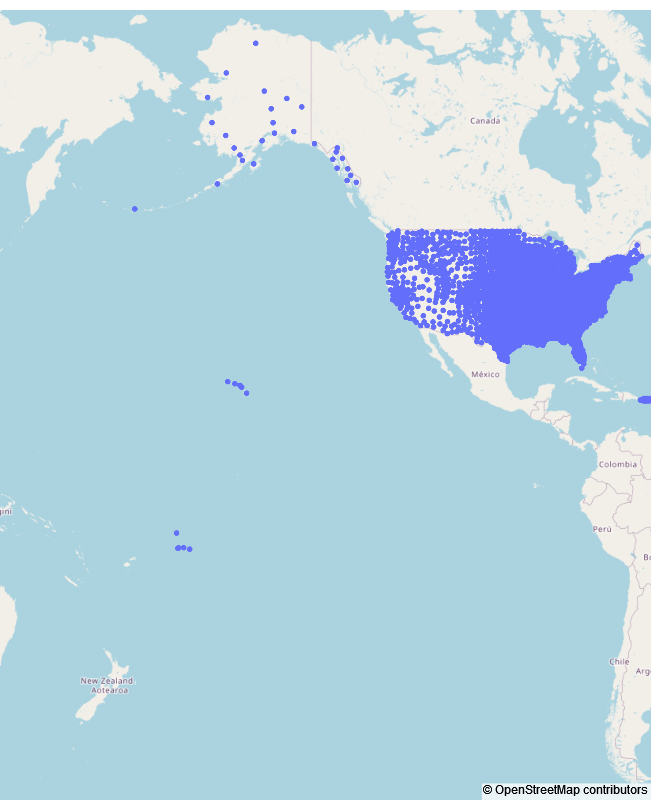

In [31]:
import plotly.express as px

color_scale = [(0, "orange"), (1, "red")]

fig = px.scatter_mapbox(
    df_boundaries,
    lat="INTPTLAT",
    lon="INTPTLON",
    color_continuous_scale=color_scale,
    zoom=8,
    height=800,
    width=800,
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

### Analyze

#### State corr

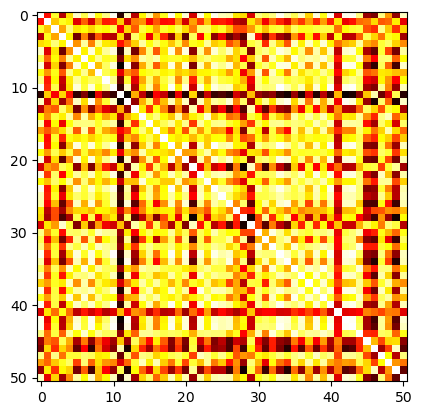

In [63]:
t0 = (
    df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
    .agg(["mean", "std"])
    .reset_index()
)
t1 = t0.pivot_table("mean", "first_day_of_month", "state").sort_index().corr()
plt.imshow(t1.values, cmap="hot", interpolation="nearest")
plt.show()

In [64]:
t1

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1.000000,-0.161415,0.596293,-0.403445,0.428137,0.896444,0.662824,0.931830,0.547988,0.769276,...,-0.301592,0.962062,0.967623,0.759326,-0.479250,-0.565229,0.764343,0.244779,-0.496868,0.883261
Alaska,-0.161415,1.000000,0.364307,0.579292,0.488680,-0.278985,0.073201,-0.317509,0.229939,-0.131077,...,0.450671,-0.251617,-0.154331,0.105262,0.144329,0.414964,0.043084,0.092883,0.472369,-0.265201
Arizona,0.596293,0.364307,1.000000,0.266485,0.743125,0.457605,0.523173,0.400820,0.559328,0.507702,...,0.110346,0.530430,0.608109,0.645275,0.036330,-0.069674,0.778480,0.368935,-0.058213,0.406732
Arkansas,-0.403445,0.579292,0.266485,1.000000,0.493871,-0.606034,0.172400,-0.543573,0.047403,-0.363068,...,0.555119,-0.404991,-0.391590,0.075038,0.678438,0.408384,0.125981,0.579678,0.503588,-0.466728
California,0.428137,0.488680,0.743125,0.493871,1.000000,0.214629,0.818200,0.165693,0.784820,0.462566,...,0.118477,0.313399,0.386400,0.821861,0.296110,0.184714,0.619764,0.708078,0.391117,0.192242
Colorado,0.896444,-0.278985,0.457605,-0.606034,0.214629,1.000000,0.489639,0.927663,0.488584,0.802712,...,-0.380417,0.901073,0.931316,0.542977,-0.434828,-0.630822,0.619734,-0.014160,-0.582363,0.814820
Connecticut,0.662824,0.073201,0.523173,0.172400,0.818200,0.489639,1.000000,0.508564,0.793592,0.584432,...,-0.141366,0.608108,0.622055,0.908608,0.145806,-0.198224,0.723389,0.741391,0.075086,0.522007
Delaware,0.931830,-0.317509,0.400820,-0.543573,0.165693,0.927663,0.508564,1.000000,0.343756,0.702683,...,-0.322251,0.973499,0.957718,0.545489,-0.521507,-0.776521,0.685977,0.085350,-0.720249,0.900933
District of Columbia,0.547988,0.229939,0.559328,0.047403,0.784820,0.488584,0.793592,0.343756,1.000000,0.664902,...,-0.171946,0.406970,0.513132,0.803645,0.044747,0.127321,0.466550,0.436034,0.346881,0.314012


In [65]:
t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
t5 = t5[t5["state"] != t5["other_state"]]

# Clean pairs of same correlations
t5 = t5.sort_values("corr").reset_index(drop=True)
cols = ["state", "other_state"]
t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
t5 = t5.drop_duplicates()

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))

t5["cluster"] = clustering.labels_
t5.groupby(["cluster"])["corr"].agg(["mean", "std"])

,mean,std
cluster,,
0,-0.883181,0.003564
1,-0.861992,0.002977
2,-0.824271,0.011028
3,-0.773983,0.014174
4,-0.720835,0.013591
5,-0.685720,0.006453
6,-0.342746,0.173984
7,0.560881,0.266506


In [75]:
t5.shape

(1275, 4)

In [76]:
corr_states = t5[abs(t5["corr"]) > 0.8]

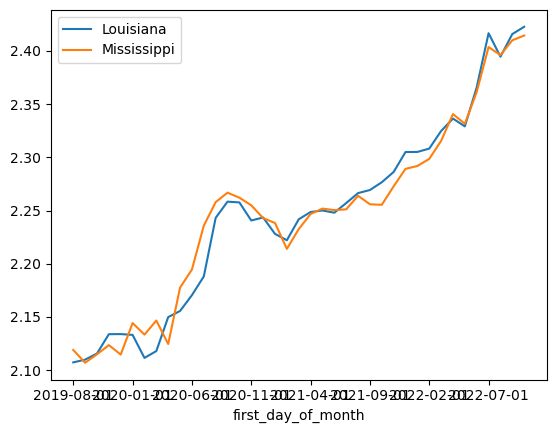

In [353]:
ax = (
    df_train[df_train["state"] == "Louisiana"]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    .plot()
)

# ax = df_train[df_train["state"] == "Mississippi"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot(ax=ax)

t9 = (
    df_train[df_train["state"] == "Mississippi"]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    + 0.55
)

t9.plot(ax=ax)

plt.legend(["Louisiana", "Mississippi"]);

In [77]:
corr_states = t5[abs(t5["corr"]) > 0.8]

#### State corr shifted

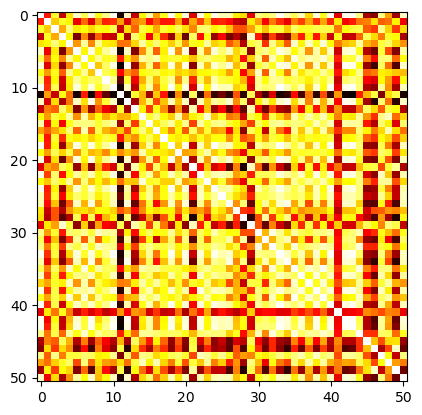

In [48]:
t0 = (
    df_train.groupby(["state", "first_day_of_month"])["microbusiness_density"]
    .agg(["mean", "std"])
    .reset_index()
)

state = "Hawaii"

t7 = t0.pivot_table("mean", "first_day_of_month", "state")
a = t7[state].shift(-6).copy()
a.index = t7.index
t7[state] = a

t1 = t7.sort_index().corr()

plt.imshow(t1.values, cmap="hot", interpolation="nearest")
plt.show()

In [49]:
t1

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
state,,,,,,,,,,,,,,,,,,,,,
Alabama,1.000000,-0.161415,0.596293,-0.403445,0.428137,0.896444,0.662824,0.931830,0.547988,0.769276,...,-0.301592,0.962062,0.967623,0.759326,-0.479250,-0.565229,0.764343,0.244779,-0.496868,0.883261
Alaska,-0.161415,1.000000,0.364307,0.579292,0.488680,-0.278985,0.073201,-0.317509,0.229939,-0.131077,...,0.450671,-0.251617,-0.154331,0.105262,0.144329,0.414964,0.043084,0.092883,0.472369,-0.265201
Arizona,0.596293,0.364307,1.000000,0.266485,0.743125,0.457605,0.523173,0.400820,0.559328,0.507702,...,0.110346,0.530430,0.608109,0.645275,0.036330,-0.069674,0.778480,0.368935,-0.058213,0.406732
Arkansas,-0.403445,0.579292,0.266485,1.000000,0.493871,-0.606034,0.172400,-0.543573,0.047403,-0.363068,...,0.555119,-0.404991,-0.391590,0.075038,0.678438,0.408384,0.125981,0.579678,0.503588,-0.466728
California,0.428137,0.488680,0.743125,0.493871,1.000000,0.214629,0.818200,0.165693,0.784820,0.462566,...,0.118477,0.313399,0.386400,0.821861,0.296110,0.184714,0.619764,0.708078,0.391117,0.192242
Colorado,0.896444,-0.278985,0.457605,-0.606034,0.214629,1.000000,0.489639,0.927663,0.488584,0.802712,...,-0.380417,0.901073,0.931316,0.542977,-0.434828,-0.630822,0.619734,-0.014160,-0.582363,0.814820
Connecticut,0.662824,0.073201,0.523173,0.172400,0.818200,0.489639,1.000000,0.508564,0.793592,0.584432,...,-0.141366,0.608108,0.622055,0.908608,0.145806,-0.198224,0.723389,0.741391,0.075086,0.522007
Delaware,0.931830,-0.317509,0.400820,-0.543573,0.165693,0.927663,0.508564,1.000000,0.343756,0.702683,...,-0.322251,0.973499,0.957718,0.545489,-0.521507,-0.776521,0.685977,0.085350,-0.720249,0.900933
District of Columbia,0.547988,0.229939,0.559328,0.047403,0.784820,0.488584,0.793592,0.343756,1.000000,0.664902,...,-0.171946,0.406970,0.513132,0.803645,0.044747,0.127321,0.466550,0.436034,0.346881,0.314012


In [50]:
t5 = t1.rename_axis(["other_state"], axis=1).stack().rename("corr").reset_index()
t5 = t5[t5["state"] != t5["other_state"]]

# Clean pairs of same correlations
t5 = t5.sort_values("corr").reset_index(drop=True)
cols = ["state", "other_state"]
t5[cols] = pd.DataFrame(np.sort(t5[cols].values, axis=1), columns=cols)
t5 = t5.drop_duplicates()

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.01, min_samples=2).fit(t5["corr"].values.reshape(-1, 1))

t5["cluster"] = clustering.labels_
t5.groupby(["cluster"])["corr"].agg(["mean", "std", "count"])

,mean,std,count
cluster,,,
-1,-0.846966,0.091663,4
0,-0.899633,0.004823,3
1,-0.870264,0.008830,7
2,-0.820720,0.016026,13
3,-0.723982,0.015836,9
4,-0.682406,0.005995,4
5,-0.647259,0.013949,15
6,-0.319367,0.162856,245
7,0.557835,0.268067,975


In [52]:
t5[t5["state"] == state].sort_values("corr")

,state,other_state,corr,cluster
0,Hawaii,Texas,-0.932125,-1
4,Hawaii,Tennessee,-0.905163,0
12,Hawaii,North Carolina,-0.879889,1
14,Hawaii,Idaho,-0.876515,1
16,Hawaii,Wyoming,-0.868376,1
22,Hawaii,Louisiana,-0.859612,1
28,Hawaii,Montana,-0.835544,2
30,Hawaii,Maryland,-0.834484,2
32,Hawaii,Pennsylvania,-0.830167,2
34,Hawaii,Nevada,-0.827150,2


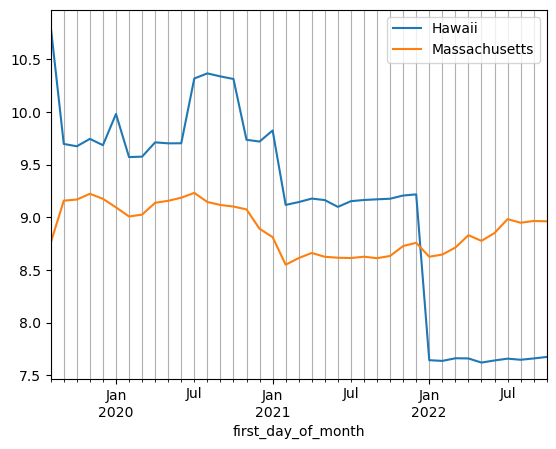

In [54]:
# ax = df_train[df_train["state"] == "Alabama"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot()

k = df_train[df_train["state"] == state].copy()
k["first_day_of_month"] = k["first_day_of_month"]  # - pd.DateOffset(months=6)

ax = (
    k.sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
    .plot()
)

# ax = df_train[df_train["state"] == "Mississippi"].sort_values("first_day_of_month").groupby(
#     "first_day_of_month"
# )["microbusiness_density"].mean().plot(ax=ax)

other = "Massachusetts"
t9 = (
    df_train[df_train["state"] == other]
    .sort_values("first_day_of_month")
    .groupby("first_day_of_month")["microbusiness_density"]
    .mean()
)

t9.plot(ax=ax)

plt.legend([state, other])

ax.grid("on", which="minor", axis="x")
ax.grid("off", which="major", axis="x")

#### Count up/down

In [198]:
def ups_downs(df_train):
    col_to_group = "cfips"

    t = df_train.copy()
    t["microbusiness_shift_diff"] = (
        t["microbusiness_density"]
        - df_train.sort_values([col_to_group, "first_day_of_month"])
        .groupby(col_to_group)
        .shift()["microbusiness_density"]
    )

    idx_over_0 = t[t["microbusiness_shift_diff"] >= 0].index
    idx_under_0 = t[t["microbusiness_shift_diff"] < 0].index

    t.loc[idx_over_0, "microbusiness_shift_bool_over"] = True
    t.loc[idx_under_0, "microbusiness_shift_bool_over"] = False

    t["microbusiness_shift_bool_over_sum"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .sum()
        .values
    )
    t["microbusiness_shift_bool_over_count"] = (
        t.groupby(col_to_group)["microbusiness_shift_bool_over"]
        .expanding()
        .count()
        .values
    )

    t["microbusiness_shift_bool_over_pct"] = (
        t["microbusiness_shift_bool_over_sum"]
        / t["microbusiness_shift_bool_over_count"]
    )

    idx = t[t["microbusiness_shift_bool_over_count"] < 3].index
    t.loc[idx, "microbusiness_shift_bool_over_pct"] = np.nan

    return t[["row_id", "microbusiness_shift_bool_over_pct"]]

In [199]:
df_ups_downs = ups_downs(df_train)

In [200]:
df_ups_downs

,row_id,microbusiness_shift_bool_over_pct
0,1001_2019-08-01,NaN
1,1001_2019-09-01,NaN
2,1001_2019-10-01,NaN
3,1001_2019-11-01,0.333333
4,1001_2019-12-01,0.500000
...,...,...
122260,56045_2022-06-01,0.705882
122261,56045_2022-07-01,0.714286
122262,56045_2022-08-01,0.694444
122263,56045_2022-09-01,0.702703


In [38]:
df_train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,58731.0,80.6,16.1,2.3,0.7,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,58731.0,80.6,16.1,2.3,0.7,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,58731.0,80.6,16.1,2.3,0.7,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,58731.0,80.6,16.1,2.3,0.7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,6
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,NaN,NaN,NaN,NaN,NaN,7
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,8
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,NaN,NaN,NaN,NaN,NaN,9


<AxesSubplot: xlabel='first_day_of_month'>

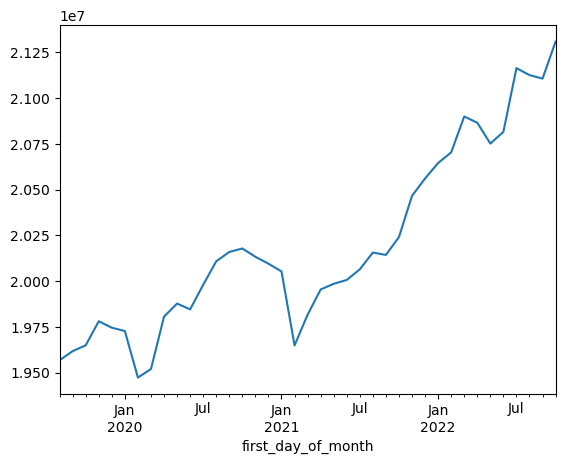

In [40]:
df_train.groupby("first_day_of_month")["active"].sum().plot()

#### t

In [410]:
k["first_day_of_month"].dtype

dtype('O')

In [205]:
t = df_train.copy()
idx = y_train.index

cols = x_train.columns.difference(df_train.columns)
cols = x_train.columns.intersection(cols)
t[cols] = x_train[cols].copy()

t.loc[idx, "target"] = (y_train - target_const).values
t.loc[idx, "pred"] = gbm.predict(x_train) - target_const
t = t.loc[idx]
t["diff"] = abs(t["target"] - t["pred"])


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


t["relative"] = t["diff"] / t["pred"]

In [151]:
t.sort_values("diff", ascending=False)[0:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,...,pct_it_workers,month,cluster,prev_mean_5_microbusiness_density,prev_mean_10_microbusiness_density,last_microbusiness_density,target,pred,diff,relative
68668,32510_2021-12-01,32510,Carson City,Nevada,2021-12-01,210.047300,91484,2021,62217.0,86.0,...,1.5,12,-1.0,203.728246,189.809892,206.807650,210.047300,27.868975,182.178325,6.536958
68669,32510_2022-01-01,32510,Carson City,Nevada,2022-01-01,208.227190,91545,2022,NaN,NaN,...,NaN,1,-1.0,206.527654,195.082030,210.047300,208.227190,27.825786,180.401404,6.483245
68667,32510_2021-11-01,32510,Carson City,Nevada,2021-11-01,206.807650,90073,2021,62217.0,86.0,...,1.5,11,-1.0,199.579372,184.282271,204.766490,206.807650,27.868975,178.938675,6.420712
68666,32510_2021-10-01,32510,Carson City,Nevada,2021-10-01,204.766490,89184,2021,62217.0,86.0,...,1.5,10,-1.0,195.104006,164.747440,202.789640,204.766490,27.868975,176.897515,6.347471
68665,32510_2021-09-01,32510,Carson City,Nevada,2021-09-01,202.789640,88323,2021,62217.0,86.0,...,1.5,9,-1.0,190.361390,145.414011,194.230150,202.789640,27.868975,174.920665,6.276537
68664,32510_2021-08-01,32510,Carson City,Nevada,2021-08-01,194.230150,84595,2021,62217.0,86.0,...,1.5,8,-1.0,183.636406,126.283821,189.302930,194.230150,27.868975,166.361175,5.969404
68663,32510_2021-07-01,32510,Carson City,Nevada,2021-07-01,189.302930,82449,2021,62217.0,86.0,...,1.5,7,-1.0,175.891538,108.009348,184.430820,189.302930,27.868975,161.433955,5.792605
68662,32510_2021-06-01,32510,Carson City,Nevada,2021-06-01,184.430820,80327,2021,62217.0,86.0,...,1.5,6,-1.0,168.985170,90.278500,181.053410,184.430820,27.868975,156.561845,5.617783
68661,32510_2021-05-01,32510,Carson City,Nevada,2021-05-01,181.053410,78856,2021,62217.0,86.0,...,1.5,5,-1.0,134.390874,73.042498,169.164720,181.053410,27.868975,153.184435,5.496594
68660,32510_2021-04-01,32510,Carson City,Nevada,2021-04-01,169.164720,73678,2021,62217.0,86.0,...,1.5,4,-1.0,100.466633,56.142618,155.505810,169.164720,27.868975,141.295745,5.070002


In [152]:
t.sort_values("relative", ascending=False)[20:40]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,...,pct_it_workers,month,cluster,prev_mean_5_microbusiness_density,prev_mean_10_microbusiness_density,last_microbusiness_density,target,pred,diff,relative
122021,56033_2022-01-01,56033,Sheridan County,Wyoming,2022-01-01,98.470734,23567,2022,NaN,NaN,...,NaN,1,-1.0,95.447606,90.911029,100.164530,98.470734,27.825786,70.644948,2.538830
64595,31009_2020-07-01,31009,Blaine County,Nebraska,2020-07-01,1.600000,6,2020,55268.0,91.6,...,0.0,7,0.0,0.533333,0.446263,0.266667,1.600000,0.454006,1.145994,2.524179
122019,56033_2021-11-01,56033,Sheridan County,Wyoming,2021-11-01,96.304420,22828,2021,62531.0,84.7,...,1.3,11,-1.0,91.528856,87.325768,92.220726,96.304420,27.857850,68.446570,2.456994
122018,56033_2021-10-01,56033,Sheridan County,Wyoming,2021-10-01,92.220726,21860,2021,62531.0,84.7,...,1.3,10,-1.0,89.622004,82.117365,90.077621,92.220726,27.857850,64.362876,2.310404
11534,8105_2022-01-01,8105,Rio Grande County,Colorado,2022-01-01,91.850067,8013,2022,NaN,NaN,...,NaN,1,-1.0,88.945122,80.322571,89.981598,91.850067,27.825786,64.024281,2.300897
122016,56033_2021-08-01,56033,Sheridan County,Wyoming,2021-08-01,90.942459,21557,2021,62531.0,84.7,...,1.3,8,-1.0,86.374452,72.915734,88.099052,90.942459,27.857850,63.084609,2.264518
11531,8105_2021-10-01,8105,Rio Grande County,Colorado,2021-10-01,90.384171,7858,2021,50287.0,73.4,...,0.5,10,-1.0,78.033125,70.886817,82.367149,90.384171,27.868984,62.515187,2.243181
11532,8105_2021-11-01,8105,Rio Grande County,Colorado,2021-11-01,90.142624,7837,2021,50287.0,73.4,...,0.5,11,-1.0,82.035886,74.524958,90.384171,90.142624,27.868984,62.273640,2.234514
122017,56033_2021-09-01,56033,Sheridan County,Wyoming,2021-09-01,90.077621,21352,2021,62531.0,84.7,...,1.3,9,-1.0,87.942962,77.244730,90.942459,90.077621,27.857850,62.219771,2.233474
11533,8105_2021-12-01,8105,Rio Grande County,Colorado,2021-12-01,89.981598,7823,2021,50287.0,73.4,...,0.5,12,-1.0,85.827007,77.622497,90.142624,89.981598,27.868984,62.112614,2.228736


<AxesSubplot: >

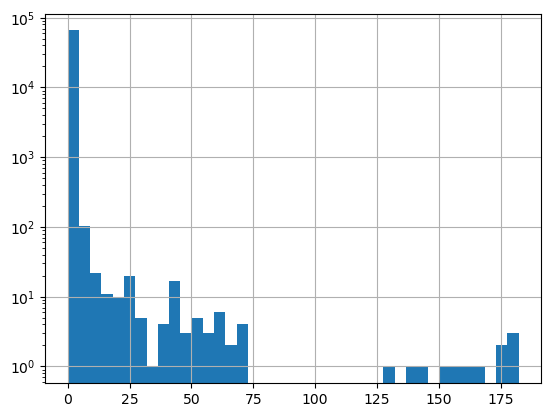

In [123]:
t["diff"].hist(bins=40, log=True)

In [127]:
t[t["diff"] > 25].set_index("first_day_of_month")

,row_id,cfips,county,state,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,cluster,prev_mean_5_microbusiness_density,prev_mean_10_microbusiness_density,last_microbusiness_density,target,pred,diff
first_day_of_month,,,,,,,,,,,,,,,,,,,,
2021-01-01,8105_2021-01-01,8105,Rio Grande County,Colorado,53.761215,4674,2021,50287.0,73.4,20.3,4.2,0.5,1,-1.0,49.942303,43.432955,49.344223,53.761215,27.868984,25.892231
2021-02-01,8105_2021-02-01,8105,Rio Grande County,Colorado,59.006210,5130,2021,50287.0,73.4,20.3,4.2,0.5,2,-1.0,52.245155,46.389490,53.761215,59.006210,27.868984,31.137226
2021-03-01,8105_2021-03-01,8105,Rio Grande County,Colorado,64.849319,5638,2021,50287.0,73.4,20.3,4.2,0.5,3,-1.0,55.284048,49.802631,59.006210,64.849319,27.868984,36.980335
2021-04-01,8105_2021-04-01,8105,Rio Grande County,Colorado,70.749939,6151,2021,50287.0,73.4,20.3,4.2,0.5,4,-1.0,59.542181,53.132803,64.849319,70.749939,27.868984,42.880955
2021-05-01,8105_2021-05-01,8105,Rio Grande County,Colorado,70.335861,6115,2021,50287.0,73.4,20.3,4.2,0.5,5,-1.0,63.740509,56.192620,70.749939,70.335861,27.868984,42.466877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,56033_2021-09-01,56033,Sheridan County,Wyoming,90.077621,21352,2021,62531.0,84.7,18.0,2.2,1.3,9,-1.0,87.942962,77.244730,90.942459,90.077621,27.857850,62.219771
2021-10-01,56033_2021-10-01,56033,Sheridan County,Wyoming,92.220726,21860,2021,62531.0,84.7,18.0,2.2,1.3,10,-1.0,89.622004,82.117365,90.077621,92.220726,27.857850,64.362876
2021-11-01,56033_2021-11-01,56033,Sheridan County,Wyoming,96.304420,22828,2021,62531.0,84.7,18.0,2.2,1.3,11,-1.0,91.528856,87.325768,92.220726,96.304420,27.857850,68.446570


In [125]:
t[t["diff"] > 25]["cfips"].value_counts()

8105     13
16021    12
32017    12
32510    12
41061    12
56033    12
Name: cfips, dtype: int64

In [118]:
x_train

,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,cluster,prev_mean_5_microbusiness_density,prev_mean_10_microbusiness_density,last_microbusiness_density
9,57982.0,82.7,16.7,2.3,0.6,0,2.963353,2.975162,3.000167
10,57982.0,82.7,16.7,2.3,0.6,0,2.973393,2.976323,3.004948
11,57982.0,82.7,16.7,2.3,0.6,0,3.008295,2.996220,3.019292
12,57982.0,82.7,16.7,2.3,0.6,0,3.056585,3.008104,3.083837
13,57982.0,82.7,16.7,2.3,0.6,0,3.097703,3.029356,3.174679
...,...,...,...,...,...,...,...,...,...
122251,65566.0,81.3,13.9,1.6,0.0,-1,1.670559,1.673360,1.670559
122252,65566.0,81.3,13.9,1.6,0.0,-1,1.666966,1.683133,1.688522
122253,65566.0,81.3,13.9,1.6,0.0,-1,1.688522,1.699299,1.670559
122254,65566.0,81.3,13.9,1.6,0.0,-1,1.717262,1.706485,1.760374


<AxesSubplot: xlabel='first_day_of_month'>

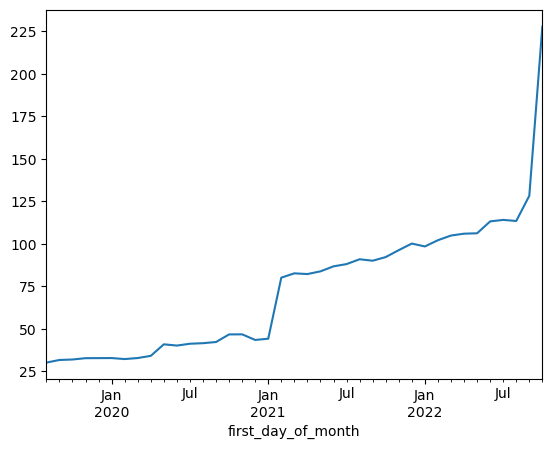

In [153]:
df_train[df_train["cfips"] == 56033].sort_values("first_day_of_month").set_index(
    "first_day_of_month"
)["microbusiness_density"].plot()

In [106]:
df_train[df_train["state"] == "Nevada"].sort_values("first_day_of_month").set_index(
    "first_day_of_month"
)

,row_id,cfips,county,state,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
first_day_of_month,,,,,,,,,,,,,
2019-08-01,32001_2019-08-01,32001,Churchill County,Nevada,3.628770,669,2019,57824.0,85.2,13.0,7.3,2.1,8
2019-08-01,32031_2019-08-01,32031,Washoe County,Nevada,9.389738,32533,2019,64791.0,85.5,19.2,14.1,1.7,8
2019-08-01,32013_2019-08-01,32013,Humboldt County,Nevada,3.142374,390,2019,67756.0,81.0,10.7,11.5,1.7,8
2019-08-01,32019_2019-08-01,32019,Lyon County,Nevada,3.385378,1379,2019,56875.0,84.8,10.3,6.9,0.5,8
2019-08-01,32017_2019-08-01,32017,Lincoln County,Nevada,4.026528,170,2019,58462.0,76.1,12.1,2.8,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,32033_2022-10-01,32033,White Pine County,Nevada,1.666236,129,2022,NaN,NaN,NaN,NaN,NaN,10
2022-10-01,32013_2022-10-01,32013,Humboldt County,Nevada,2.269973,281,2022,NaN,NaN,NaN,NaN,NaN,10
2022-10-01,32019_2022-10-01,32019,Lyon County,Nevada,3.387204,1486,2022,NaN,NaN,NaN,NaN,NaN,10


In [104]:
df_train[df_train["state"] == "Nevada"].tail(50)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month
68629,32033_2021-12-01,32033,White Pine County,Nevada,2021-12-01,1.547464,119,2021,63590.0,78.1,10.1,4.2,0.2,12
68630,32033_2022-01-01,32033,White Pine County,Nevada,2022-01-01,1.537071,119,2022,NaN,NaN,NaN,NaN,NaN,1
68631,32033_2022-02-01,32033,White Pine County,Nevada,2022-02-01,1.562904,121,2022,NaN,NaN,NaN,NaN,NaN,2
68632,32033_2022-03-01,32033,White Pine County,Nevada,2022-03-01,1.549987,120,2022,NaN,NaN,NaN,NaN,NaN,3
68633,32033_2022-04-01,32033,White Pine County,Nevada,2022-04-01,1.575820,122,2022,NaN,NaN,NaN,NaN,NaN,4
68634,32033_2022-05-01,32033,White Pine County,Nevada,2022-05-01,1.575820,122,2022,NaN,NaN,NaN,NaN,NaN,5
68635,32033_2022-06-01,32033,White Pine County,Nevada,2022-06-01,1.601653,124,2022,NaN,NaN,NaN,NaN,NaN,6
68636,32033_2022-07-01,32033,White Pine County,Nevada,2022-07-01,1.614570,125,2022,NaN,NaN,NaN,NaN,NaN,7
68637,32033_2022-08-01,32033,White Pine County,Nevada,2022-08-01,1.614570,125,2022,NaN,NaN,NaN,NaN,NaN,8
68638,32033_2022-09-01,32033,White Pine County,Nevada,2022-09-01,1.653320,128,2022,NaN,NaN,NaN,NaN,NaN,9


In [27]:
t[5:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,prev_mean_microbusiness_density,last_microbusiness_density,target,pred
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,57982.0,82.7,16.7,2.3,0.6,1,2.979254,2.993233,2.969090,2.986940
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,57982.0,82.7,16.7,2.3,0.6,2,2.984145,2.969090,2.909326,2.951913
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,57982.0,82.7,16.7,2.3,0.6,3,2.959623,2.909326,2.933231,2.919727
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,57982.0,82.7,16.7,2.3,0.6,4,2.961010,2.933231,3.000167,2.943040
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,57982.0,82.7,16.7,2.3,0.6,5,2.963353,3.000167,3.004948,2.992135
10,1001_2020-06-01,1001,Autauga County,Alabama,2020-06-01,3.019292,1263,2020,57982.0,82.7,16.7,2.3,0.6,6,2.973393,3.004948,3.019292,2.992135
11,1001_2020-07-01,1001,Autauga County,Alabama,2020-07-01,3.083837,1290,2020,57982.0,82.7,16.7,2.3,0.6,7,3.008295,3.019292,3.083837,3.006168
12,1001_2020-08-01,1001,Autauga County,Alabama,2020-08-01,3.174679,1328,2020,57982.0,82.7,16.7,2.3,0.6,8,3.056585,3.083837,3.174679,3.082674
13,1001_2020-09-01,1001,Autauga County,Alabama,2020-09-01,3.205756,1341,2020,57982.0,82.7,16.7,2.3,0.6,9,3.097703,3.174679,3.205756,3.170510
14,1001_2020-10-01,1001,Autauga County,Alabama,2020-10-01,3.193804,1336,2020,57982.0,82.7,16.7,2.3,0.6,10,3.135474,3.205756,3.193803,3.186211


In [111]:
t.loc[6:6].dropna(axis=1)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,...,corr_Texas_Alabama_mean_microbusiness_density,Texas_Alabama_mean_microbusiness_density,corr_Louisiana_Alabama_mean_microbusiness_density,Louisiana_Alabama_mean_microbusiness_density,corr_Georgia_Alabama_mean_microbusiness_density,Georgia_Alabama_mean_microbusiness_density,corr_South Carolina_Alabama_mean_microbusiness_density,South Carolina_Alabama_mean_microbusiness_density,target,pred
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,57982.0,82.7,...,0.967623,3.151997,0.968619,2.133145,0.974307,3.173852,0.975245,3.033582,2.909326,2.938182


<AxesSubplot: >

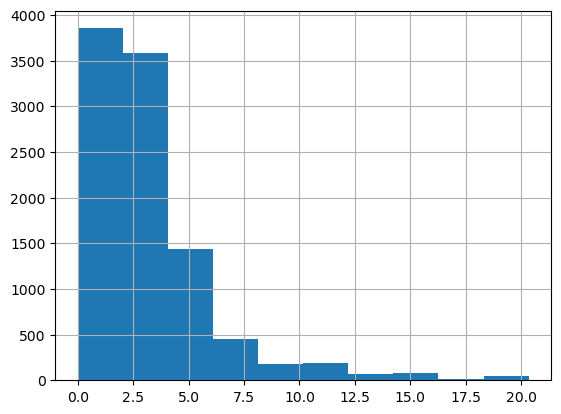

In [98]:
t[t["state"] == "Texas"]["microbusiness_density"].hist()

<AxesSubplot: >

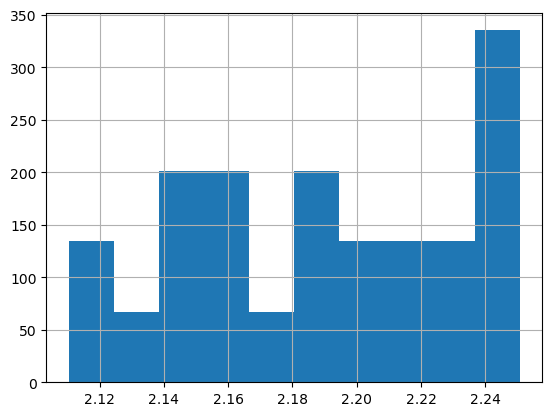

In [96]:
t[~t["Alabama_Texas_mean_microbusiness_density"].isna()][
    "Alabama_Texas_mean_microbusiness_density"
]

In [112]:
def smape_pandas(pred, eval_data):
    A = eval_data
    F = pred

    value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

In [113]:
smape_pandas(t["pred"], t["target"])

('smape', 1.287888478343007, False)

In [114]:
t.shape

(122265, 386)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

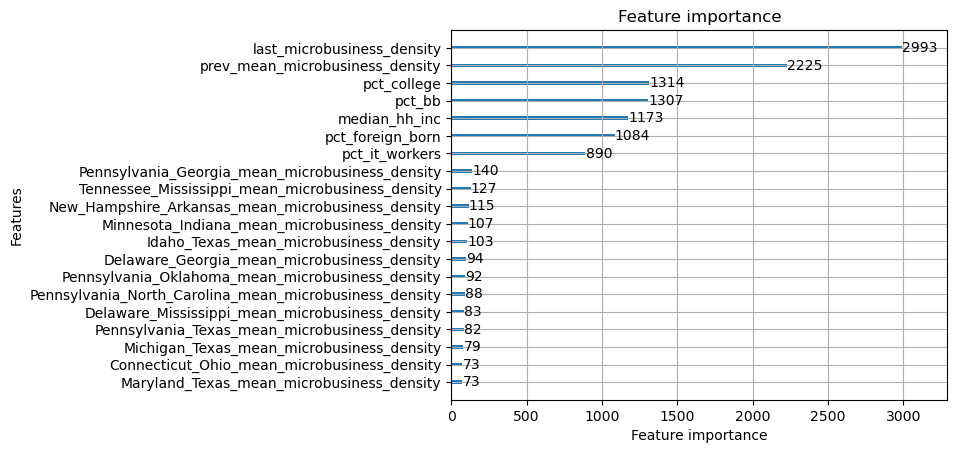

In [120]:
lgb.plot_importance(gbm, max_num_features=20)

In [131]:
df_f = pd.DataFrame([gbm.feature_importance()], columns=gbm.feature_name()).T.rename(
    columns={0: "f_importance"}
)

In [138]:
df_f.sort_values("f_importance", ascending=False).head(20).index.values

array(['last_microbusiness_density', 'prev_mean_microbusiness_density',
       'pct_college', 'pct_bb', 'median_hh_inc', 'pct_foreign_born',
       'pct_it_workers',
       'Pennsylvania_Georgia_mean_microbusiness_density',
       'Tennessee_Mississippi_mean_microbusiness_density',
       'New_Hampshire_Arkansas_mean_microbusiness_density',
       'Minnesota_Indiana_mean_microbusiness_density',
       'Idaho_Texas_mean_microbusiness_density',
       'Delaware_Georgia_mean_microbusiness_density',
       'Pennsylvania_Oklahoma_mean_microbusiness_density',
       'Pennsylvania_North_Carolina_mean_microbusiness_density',
       'Delaware_Mississippi_mean_microbusiness_density',
       'Pennsylvania_Texas_mean_microbusiness_density',
       'Michigan_Texas_mean_microbusiness_density',
       'Connecticut_Ohio_mean_microbusiness_density',
       'Maryland_Texas_mean_microbusiness_density'], dtype=object)

In [123]:
gbm.feature_importance()

array([1173, 1307, 1314, 1084,  890, 2225, 2993,   10,    0,   19,    9,
         13,  127,   41,   88,   83,    0,   35,    5,    0,   14,    0,
        115,   33,   45,    1,    0,   24,    5,   15,    8,   41,   10,
         20,   27,   47,   12,   10,    7,   33,   32,   18,   13,    0,
         20,   10,    7,    0,    0,    6,  140,   42,   31,    5,    0,
          0,   43,   17,   18,   49,   92,   94,    0,   73,    0,    0,
          2,   34,    0,   30,    6,   67,  107,    0,   20,   19,    1,
          2,   51,   21,    0,   46,    0,    0,   26,  103,    0,   65,
         17,   10,   51,    0,   44,    7,   56,   58,    0,   73,    0,
          9,    0,    1,   26,    0,    3,   79,    4,   12,    5,   20,
          1,   15,    5,   33,    2,    2,    0,   27,    7,   82,    2,
          5,   34,   31,   50,   22,   13,    8,   11,   31,    3,   20,
         33,    8,    0,   25,   59,    2,   42,    0,    8,   45,    5,
         33,   28,   14,    5,   33,    0,   12,   

In [126]:
gbm.feature_name()

['median_hh_inc',
 'pct_bb',
 'pct_college',
 'pct_foreign_born',
 'pct_it_workers',
 'prev_mean_microbusiness_density',
 'last_microbusiness_density',
 'Delaware_Wyoming_mean_microbusiness_density',
 'Wyoming_Delaware_mean_microbusiness_density',
 'Colorado_Tennessee_mean_microbusiness_density',
 'Tennessee_Colorado_mean_microbusiness_density',
 'Mississippi_Tennessee_mean_microbusiness_density',
 'Tennessee_Mississippi_mean_microbusiness_density',
 'North_Carolina_Pennsylvania_mean_microbusiness_density',
 'Pennsylvania_North_Carolina_mean_microbusiness_density',
 'Delaware_Mississippi_mean_microbusiness_density',
 'Mississippi_Delaware_mean_microbusiness_density',
 'Maryland_North_Dakota_mean_microbusiness_density',
 'North_Dakota_Maryland_mean_microbusiness_density',
 'Oregon_Rhode_Island_mean_microbusiness_density',
 'Rhode_Island_Oregon_mean_microbusiness_density',
 'Arkansas_New_Hampshire_mean_microbusiness_density',
 'New_Hampshire_Arkansas_mean_microbusiness_density',
 'Oklaho

In [269]:
train["pred"] = gbm.predict(x_train)

In [271]:
train[["microbusiness_density", "pred"]]

,microbusiness_density,pred
0,3.007682,4.482357
1,2.884870,4.482357
2,3.055843,4.482357
3,2.993233,4.482357
4,2.993233,4.482357
...,...,...
122248,1.652596,3.777928
122249,1.652596,3.777928
122250,1.670559,3.777928
122251,1.688522,3.777928


In [32]:
df_test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [10]:
df_census.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

In [23]:
df_census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


In [14]:
df_train.sort_values("first_day_of_month")

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
41613,21153_2019-08-01,21153,Magoffin County,Kentucky,2019-08-01,0.336289,33
80652,39057_2019-08-01,39057,Greene County,Ohio,2019-08-01,5.733927,7490
5460,5063_2019-08-01,5063,Independence County,Arkansas,2019-08-01,1.865025,527
116805,54021_2019-08-01,54021,Gilmer County,West Virginia,2019-08-01,0.526540,37
...,...,...,...,...,...,...,...
26675,17181_2022-10-01,17181,Union County,Illinois,2022-10-01,1.637489,217
95588,47053_2022-10-01,47053,Gibson County,Tennessee,2022-10-01,2.517291,939
43133,21229_2022-10-01,21229,Washington County,Kentucky,2022-10-01,1.592288,147
105143,48353_2022-10-01,48353,Nolan County,Texas,2022-10-01,1.502534,166


## Stuff

In [159]:
t = 10
(9.8 / t) * (t / 1000)

0.009800000000000001

<AxesSubplot: >

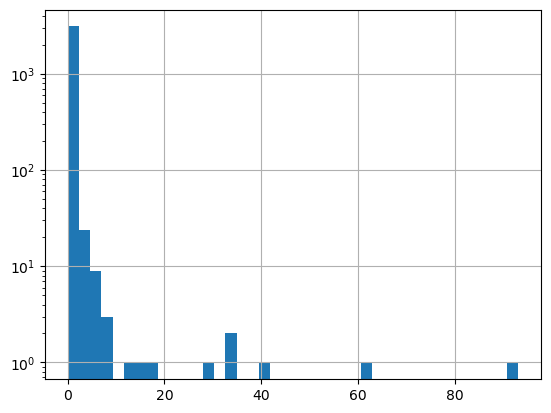

In [36]:
df_train.groupby("cfips")["microbusiness_density"].agg(["std", "mean"])["std"].hist(
    bins=40, log=True
)

In [191]:
df_train.groupby("cfips")["microbusiness_density"].agg(["std", "mean"]).sort_values(
    "std"
)

,std,mean
cfips,,
51081,0.012630,0.164327
48427,0.012740,0.527867
13101,0.015007,0.073227
39037,0.018606,1.849626
29181,0.018863,0.814338
...,...,...
32017,33.919938,40.140351
16021,34.517087,46.730638
56033,40.598497,73.510410


In [192]:
df_train.groupby("cfips")["microbusiness_density"].agg(["std", "mean"]).sort_values(
    "std"
).tail(30)

,std,mean
cfips,,
12131,3.611749,21.533259
41061,3.655814,54.522958
30067,3.827627,15.685004
8031,3.965239,16.378688
15005,4.029055,7.735287
10003,4.137013,18.231214
38101,4.140873,7.867746
30045,4.484231,7.834519
21215,4.605657,7.147836


In [195]:
df_train[df_train["cfips"] == 12045]["microbusiness_density"].agg(
    ["std", "mean", "median"]
)

std       6.423519
mean      8.018057
median    4.552227
Name: microbusiness_density, dtype: float64

In [196]:
df_train[df_train["cfips"] == 12045]["microbusiness_density"]

13221     4.408387
13222     4.489887
13223     4.497296
13224     4.519523
13225     4.519523
13226     4.552227
13227     4.500074
13228     4.418119
13229     4.522426
13230    18.693190
13231    19.296677
13232    20.101326
13233    20.570705
13234    20.086426
13235    19.795858
13236    19.140217
13237    18.998659
13238    19.558214
13239     4.609603
13240     4.647952
13241     4.586593
13242     4.548243
13243     4.486885
13244     4.440865
13245     4.525234
13246     4.433195
13247     4.440865
13248     4.471545
13249     4.463875
13250     4.468927
13251     4.530995
13252     4.593064
13253     4.593064
13254     4.546513
13255     4.616340
13256     4.748235
13257     4.748235
13258     4.779269
13259     4.755993
Name: microbusiness_density, dtype: float64

In [33]:
df_train[df_train["cfips"] == 32510]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
68640,32510_2019-08-01,32510,Carson City,Nevada,2019-08-01,11.617217,5004
68641,32510_2019-09-01,32510,Carson City,Nevada,2019-09-01,11.357200,4892
68642,32510_2019-10-01,32510,Carson City,Nevada,2019-10-01,11.563821,4981
68643,32510_2019-11-01,32510,Carson City,Nevada,2019-11-01,11.352556,4890
68644,32510_2019-12-01,32510,Carson City,Nevada,2019-12-01,11.296838,4866
68645,32510_2020-01-01,32510,Carson City,Nevada,2020-01-01,11.617307,5021
68646,32510_2020-02-01,32510,Carson City,Nevada,2020-02-01,11.450717,4949
68647,32510_2020-03-01,32510,Carson City,Nevada,2020-03-01,11.485423,4964
68648,32510_2020-04-01,32510,Carson City,Nevada,2020-04-01,11.628876,5026
68649,32510_2020-05-01,32510,Carson City,Nevada,2020-05-01,11.557150,4995


In [18]:
df_train[df_train["cfips"] == 46127]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
94380,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.535980,31245
94381,46127_2019-09-01,46127,Union County,South Dakota,2019-09-01,5.880263,662
94382,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011
94383,46127_2019-11-01,46127,Union County,South Dakota,2019-11-01,5.871380,661
94384,46127_2019-12-01,46127,Union County,South Dakota,2019-12-01,5.862498,660
94385,46127_2020-01-01,46127,Union County,South Dakota,2020-01-01,5.733148,660
94386,46127_2020-02-01,46127,Union County,South Dakota,2020-02-01,5.542043,638
94387,46127_2020-03-01,46127,Union County,South Dakota,2020-03-01,5.437804,626
94388,46127_2020-04-01,46127,Union County,South Dakota,2020-04-01,5.724462,659
94389,46127_2020-05-01,46127,Union County,South Dakota,2020-05-01,5.759208,663


In [29]:
from sklearn.ensemble import IsolationForest

X = df_train[df_train["cfips"] == 46127]["microbusiness_density"].values.reshape(-1, 1)
clf = IsolationForest(n_estimators=1000, random_state=0).fit(X)
res = clf.predict(X)

In [30]:
res

array([-1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

In [31]:
df_train[df_train["cfips"] == 46127]["microbusiness_density"].values

array([277.53598  ,   5.8802629, 284.34003  ,   5.8713803,   5.8624978,
         5.7331481,   5.5420432,   5.4378042,   5.7244616,   5.7592077,
         5.6984015,   5.6202226,   5.6636553,   5.5681028,   5.5159831,
         5.611536 ,   5.4638638,   5.384285 ,   5.0923142,   5.1524258,
         5.135251 ,   5.2211251,   5.2554746,   5.2640619,   5.2812366,
         5.2812366,   5.4701591,   5.4787464,   5.4701591,   5.4350576,
         5.4519367,   5.4434972,   5.4772553,   5.4181786,   5.5616508,
         5.6629252,   5.6291671,   5.6038485,   5.5954089])

In [32]:
clf = LocalOutlierFactor(n_neighbors=2)
clf.fit_predict(X)

clf.negative_outlier_factor_

array([-1.03225068e+04, -8.75000704e-01, -1.03225068e+04, -1.33333083e+00,
       -8.75000704e-01, -1.00000740e+00, -9.38103425e-01, -1.07614183e+00,
       -9.99992599e-01, -9.99995066e-01, -9.45495662e-01, -1.25209524e+00,
       -1.78400299e+00, -9.38103425e-01, -2.71096497e+00, -6.80566303e-01,
       -1.00000000e+00, -4.15508670e+00, -9.28571191e-01, -9.28571191e-01,
       -1.16666731e+00, -1.80000559e+00, -1.12499927e+00, -1.12499927e+00,
       -9.00000466e-01, -9.00000466e-01, -1.00000000e+00, -1.12282576e+00,
       -1.00000000e+00, -8.19678308e-01, -1.38673836e+00, -9.54523652e-01,
       -1.12282576e+00, -2.37285836e+00, -1.14128302e+00, -1.78400299e+00,
       -1.26926488e+00, -1.21871665e+00, -1.20160824e+00])